# Processing Quadview data

The quadview unit splits the emission in four seperate channels that are projected on a single camera. The purpose of this notebook is to split the image in four channels and align these channels. The result is 4-channel data that can be used for further image analysis

In [1]:
import skimage
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%cd Split-and-align_data

/Users/joachimgoedhart/surfdrive/Python/Split-and-align_data


Below we load sample data acquired with the Quadview unit

In [3]:
im_raw = skimage.io.imread("quadview.tif")

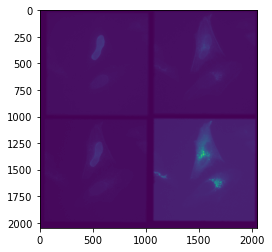

In [4]:
plt.imshow(im_raw)

Get the dimension of the image:

In [5]:
nrows, ncols = im_raw.shape

## Split the image in four squares with identical dimensions and assign these as channels

Define the size of the split images (original dimensions divided by 2):

In [6]:
rsplit, csplit = nrows // 2, ncols // 2

Assign quadrants:

In [7]:
from skimage.util import view_as_blocks

quadrants = view_as_blocks(im_raw, (rsplit, csplit)).reshape(
    (4, rsplit, csplit)
)

Let's look at quadrant with index 1 (the second quadrant)

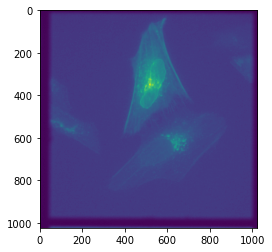

In [8]:
plt.imshow(quadrants[1])

Identify the different slices as channels:

In [9]:
n_channels, nrows, ncols = quadrants.shape

Save the data:

In [10]:
#Save split image as 4 16bit channels
skimage.io.imsave('split.tif', quadrants)

/var/folders/71/9n0dk57x7p15278hh_rf39h00000gn/T/ipykernel_18285/821072657.py:2: UserWarning: split.tif is a low contrast image
  skimage.io.imsave('split.tif', quadrants)


In [11]:
from skimage.util import img_as_float #Sobel creates a floating point image

q_float = img_as_float(quadrants)

## Apply a sobel filter to show the edges for each image

Next, we need to align the images. To achieve this, an edge filter will be used to generate features in the image that are sharp, facilitating the alignment. Here, we use a Sobel filter:

In [12]:
from skimage import filters #needed for sobel filter
from skimage import exposure #needed for rescaling

#Generate a new empty array
edges = np.empty_like(q_float)
for pln, image in enumerate(q_float):
    # Iterate over the leading dimension
    edges[pln] = filters.sobel(image)
    #rescale values between (0,1)
    edges[pln] = exposure.rescale_intensity(edges[pln])

Let's look at the result of the filter:

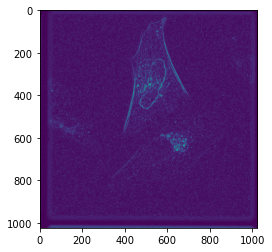

In [13]:
plt.imshow(edges[1])

In [14]:
n_channel,n_row,n_col = edges.shape

## Make a montage of the result, showing all 4 channels

Below, we make a montage of the channels, for displaying the result side-by-side

In [15]:
montage = np.zeros((n_row, n_col*n_channel+40))

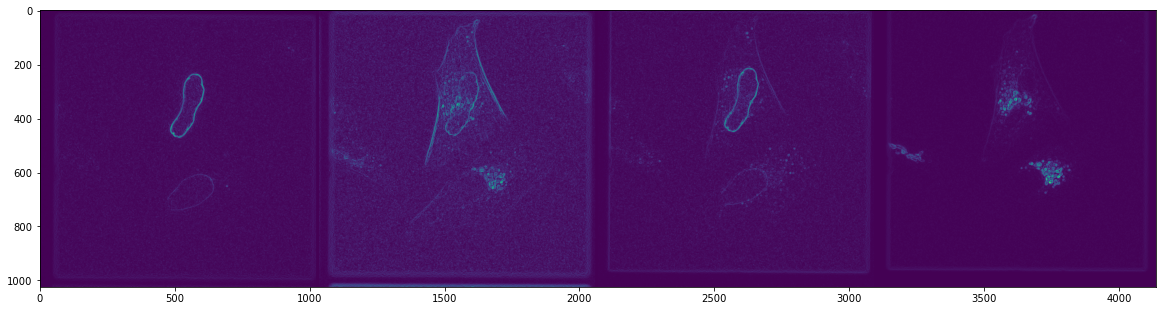

In [16]:
for i in range(n_channel):
    start = i*n_col
    end = i*n_col+n_col
    montage[0:n_row,start+i*10:end+i*10]=edges[i,0:n_row,0:n_col]
    
plt.figure(figsize=(20,15))
plt.imshow(montage)

In [17]:
skimage.io.imsave('split_filtered.tif', edges)

In [18]:
edges.shape

(4, 1024, 1024)

## Aligning the images

Next, we can align the filtered images and apply the alignment parameters to align the original stack

In [19]:
from pystackreg import StackReg

In [20]:
#Rigid Body transformation
sr = StackReg(StackReg.RIGID_BODY)

In [21]:
out_rot = sr.register_transform(edges[0], edges[1])

Let's look at the result:

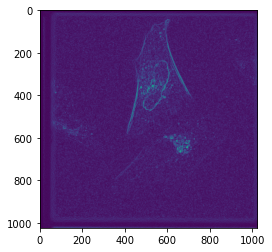

In [22]:
plt.imshow(out_rot)

In [23]:
# register each frame to the previous (already registered) one
tmats = sr.register_stack(edges, reference='previous')

The parameters for correct alignment are printed below as a 3x3 affine tranformation matrix. The affine transformation matrix can correct for scaling, rotation and shearing. 

In [24]:
tmats

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.00000000e+00,  1.28571674e-06, -1.50230765e+01],
        [-1.28571674e-06,  1.00000000e+00, -7.83412290e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 9.99968272e-01, -7.96586665e-03, -1.06774038e+01],
        [ 7.96586665e-03,  9.99968272e-01, -2.65949088e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 9.99999973e-01, -2.32943859e-04, -1.73880565e+01],
        [ 2.32943859e-04,  9.99999973e-01, -2.76022361e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]])

In [25]:
quad_aligned = np.empty_like(quadrants)

Below, the transformation matrix is applied to the original stack:

In [26]:
# apply to original:
quad_aligned = sr.transform_stack(quadrants, tmats=tmats)

In [27]:
#Save aligned images
skimage.io.imsave('aligned.tif', quad_aligned)